# Introduction

This is a story of my quest to learn some data science and machine learning. It is not a noble or heroic story, however for the benefit of the enjoyment of the reader I will try me best to phrase it as though it were. After learning some of the basics of machine learning and some tools of the trade. I set out on a quest to find a beast to slay with my new found weapons. As opposed to mythology and fairy tales where it seems there is always a dragon ravaging a conveniently near by town, I found that interesting data sets are much harder to come by, my first few days where spend wading through mountains of shit. I was not feeling particularly heroic until I remembers the fifth labor of Hercules, cleaning up King Augeas' stables. Perhaps a data scientist of mythological proportions could have done the metaphorical equivalent of rerouting a river. However for those of us not blessed with the good fortune of being spawned by a god, we must start our lives as lowly stable hands. And thus I began my first labor (personally I am glad to have skipped Hercules first five as I am not sure how I would have fared in a battle against a hydra).

I started browsing though publicly provided government data with not particular project in mind, hoping that something would strike my fancy. But when ever something did I always found my self disappointed in the data I was given. So I decided to focus on a single topic, something I know about and was interested in, computer games. First I looked at Hearthstone. While I was able to find some data it was again fairly restricted. As large companies don't tend to be free with their data, all the data had been collect by a small group of players using image capture software and thus was quite limited and had already been highly analysed.
## Kingdom of Loathing
So I turned to a much smaller game that allows bots and is known to be much more open with their data, Kingdom of Loathing. Kingdom of Loathing is an absurdist mostly text based game (the text is reinforced with picture but they keep them selves to stick figure art) largest based on puns and parodies. I will focus on one small part of the game, the meat market. In KoL players can trade items using the in game currency meat, why it is meat only god and Jick (the creator of the game) know.

Logging into the KoL wiki I found that they had hourly transaction data for the past year on all items purchased on the in game KoL mall. At last I had found a data set large enough, interesting enough and that even tickled my funny bone. And thus the stables were cleaned. Or so I thought (ominous music).

In [1]:
#primary packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, learning_curve, validation_curve
from sklearn.metrics import recall_score, precision_score, f1_score
import datetime as dt
import calendar
from itertools import product

#Custom packages
from model_selection_functions import Train_Accucary
from Convert_Kol import Convert_Kol
from Mean_SD import Mean_SD

I focus my analysis on a single item, the Mr. Accessory. This items occupy a special place in the KoL economy. Kingdom of Loathing earns it revenue exclusively though selling Mr. Accessories with one Mr. Accessory selling for $10, alternatively people can buy Mr. Accessories that other players are selling for the in game currency. Every month a new unique item of the month is created that can only be purchased by trading in a Mr. Accessory thus Mr. Accessories enter and leave the game constantly and their value goes through fluctuates based on the item they can be traded for.

# Importing the data and familiarizing myself with the data

Any great warrior knows that his weapon is his lifeline. Thus is important to keep it clean and to know its ins and outs, from it balance to the feel of its grip. For me my weapon is my data and now that I have drawn my weapon from the stone I must clean it and learn the feel of it. Else I can not hope to succeed in my quest.

In [2]:
#Get the data in the right form and import it
path = os.path.join(os.getcwd(),'mr_A')
Convert_Kol(path,'CSV_Mr_A')#Custom script that changes the human readable format the data was given in to a CSV file
path = os.path.join(os.getcwd(),'CSV_Mr_A.csv')
Mr_A_Data=pd.read_csv(path)
Mr_A_Data.head(10)

,Month,Day,Time,Quantity,Cost
0,May,24,15.0,2,26575000.0
1,May,24,15.5,4,27150000.0
2,May,24,16.5,1,27150000.0
3,May,24,18.5,1,27100000.0
4,May,24,19.0,1,27000000.0
5,May,24,19.5,3,26607000.0
6,May,24,20.0,1,26500000.0
7,May,24,20.5,2,26900000.0
8,May,24,21.0,1,26900000.0
9,May,24,21.5,3,27000000.0


Now let look at some simple plots. The majority of KoL players are in North America and as people tend to play computer games at similar times of day it seems reasonable to think that there will be some relation between quantity purchases and time of day.

In [3]:
#Get the data in the form to make a graph to adress this question.
Volumn_Data=Mr_A_Data.iloc[:,2:4]
Volumn_Data = Volumn_Data.groupby('Time').sum()
Volumn_Data['Time']=Volumn_Data.index
Volumn_Data.index.names = ['index']

In [4]:
#Answers the question of haw many days does the data cover, this is nessacary as the data has days missing here and there.
temp = Mr_A_Data.loc[:,['Month','Day']]
temp['Stuff']=0
temp = temp.groupby(['Month','Day']).sum()
temp['Stuff'].shape[0]

12L

It order to get a feal for how large the market is it is useful to note that this data is from the transactions of 12 days.

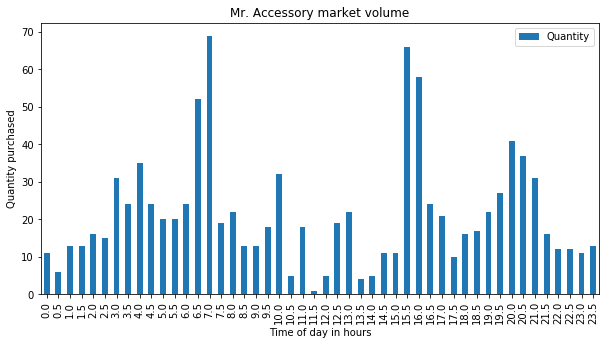

In [5]:
#plot the graph
Volumn_Plot = Volumn_Data.plot(x='Time',y='Quantity',kind='bar',figsize=(10,5))
Volumn_Plot.set_ylabel('Quantity purchased')
Volumn_Plot.set_xlabel('Time of day in hours')
Volumn_Plot.set_title('Mr. Accessory market volume')

It is useful to note at this point that this data is given with respect to the west coast time zone. We see two clear peaks in this data and one smaller one. So it seems likely that market traffic does vary significantly with time. The first peak is around 6:30 am to 7:00 am I suspect this corresponds to people who play the game when the get up in the morning before they go to work or school. I personally fall into this category. The dip in the middle is when people are at work or school. The peak at 4:00 pm (7:00 pm east coast) is likely people on the east coast playing when they get off work and the west coast playing when the get off school. The last smaller peak are around 8:00 pm is likely from people on the west coast getting off work. The next question I wish to address is does this increased traffic affect the costs. If so is there a best time of day for me to purchase (or sell) items in KoL?

In [6]:
#Get the data in the form to make a graph to adress this question.
Price_Data = Mr_A_Data.iloc[:,2:]
Price_Data['Total Cost']=Price_Data['Quantity']*Price_Data['Cost']
Price_Data=Price_Data.iloc[:,[0,1,3]]
Price_Data = Price_Data.groupby('Time').sum()
Price_Data['Mean Cost']=Price_Data['Total Cost']/Price_Data['Quantity']
Price_Data['Time']=Price_Data.index
Price_Data=Price_Data.iloc[:,2:]
Price_Data['Mean Cost']=Price_Data['Mean Cost']-min(Price_Data['Mean Cost'])

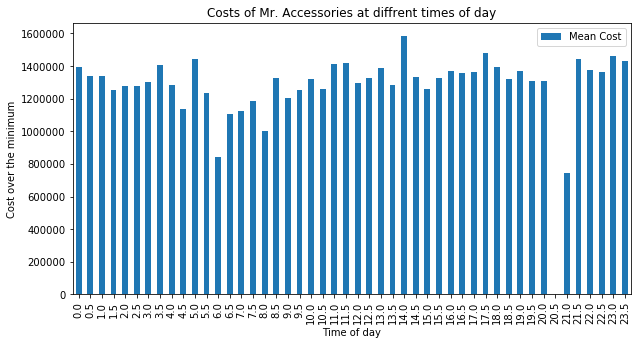

In [7]:
#Graph price vs time of day
Price_Plot = Price_Data.plot(x='Time',y='Mean Cost',kind='bar',figsize=(10,5))
Price_Plot.set_ylabel('Cost over the minimum')
Price_Plot.set_xlabel('Time of day')
Price_Plot.set_title('Costs of Mr. Accessories at diffrent times of day')

This Graph looks fairly flat so it seems likely that the time of day does not matter.  Perhaps there is something going on at around 8:30 pm. Lets take a look at that data and see what is going on there.

In [12]:
Mr_A_Data[Mr_A_Data['Time']==20.5]

,Month,Day,Time,Quantity,Cost
7,May,24,20.5,2,26900000.0
52,May,26,20.5,4,27287500.0
73,May,27,20.5,24,25000000.0
90,May,28,20.5,1,27275000.0
134,May,30,20.5,3,27329500.0
158,May,31,20.5,1,27492000.0
221,Jun,2,20.5,1,27300000.0
258,Jun,3,20.5,1,27000000.0


It now seems clear why we have the dip at 20.5. It is due to a massive sale on may 27. Since the pattern does not persist across different days I am willing to dismiss it as an outlier. I am also guess due to the increase in quantity sold at this time I am guessing it was a single seller, but unfortunately I have no way to confirm this.

Now let us look at a plot of the amount of Mr. As bought at diffrent prices. This will help the wise investor know what is a good price to buy at and what is a good price to sell at and how often one should expect to find these deals.

In [13]:
#Get the data in the form to make a graph to adress this question.
Price_Freq = Mr_A_Data.iloc[:,3:]
Price_Freq['Cost']=Price_Freq['Cost'].apply(lambda x: math.floor(x/100000))#People often undercut each others prices by a trivial
#amount in order to have the cheapest price so we will round our costs to the nearest 100,000 meat.
Price_Freq=Price_Freq.groupby('Cost').sum()
Price_Freq['Cost']=Price_Freq.index

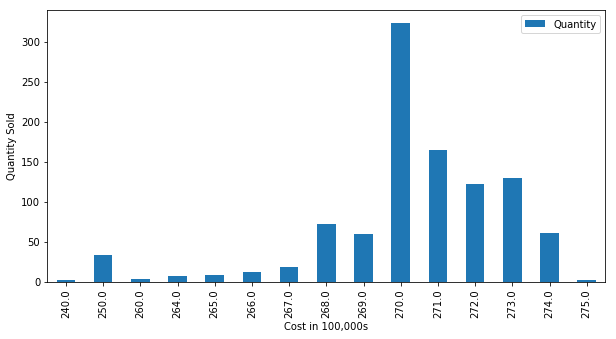

In [14]:
#Graph price vs time of day
Price_Freq_Plot = Price_Freq.plot(x='Cost',y='Quantity',kind='bar',figsize=(10,5))
Price_Freq_Plot.set_ylabel('Quantity Sold')
Price_Freq_Plot.set_xlabel('Cost in 100,000s')

This seems to follow a left skewed Gaussian distribution of some kind. We have already seen where the small spike at 25 million comes from. The Quantity sold seems to fall off very quickly after 27 million. So it seems like the wise investor should focus more on buying low rather then selling high. This agrees with my experiences in game often I need get fast cash which result in me needed to sell items well below market value.

# Monthly Price tends
People tend to be procrastinators. Investors in KoL have long know how to take advantage of this fact. They believe the price of Mr. As tends to increase near the end of the month as people rush to purchase the items of the month before Mr. Store stops selling it. In this section I would like to try to find when is the best time to buy and sell Mr. As with respect to this monthly cycle. For this section we will use a different data set. It has all the data from the past year but the data is stored by the day and not the half hour so it would not be useful in answering the hourly question.

In [15]:
#Compress the data sorted by time to the day is was sold by taking the mean over all times of that day.
path = os.path.join(os.getcwd(),'Mr_A_Year')
Convert_Kol(path,'CSV_Mr_A_Year')
path = os.path.join(os.getcwd(),'CSV_Mr_A_Year.csv')
Mr_A_Data_Year=pd.read_csv(path)
del Mr_A_Data_Year['Time']
Day_of_Month_Data = Mr_A_Data_Year.loc[:,['Month','Day','Quantity','Cost']]
Day_of_Month_Data=Day_of_Month_Data[Day_of_Month_Data['Month']!='Jun']
Day_of_Month_Data['Total Cost']=Day_of_Month_Data['Cost']*Day_of_Month_Data['Quantity']
Day_of_Month_Data=Day_of_Month_Data.groupby(['Month','Day']).sum()
Day_of_Month_Data['Cost'] = Day_of_Month_Data['Total Cost']/Day_of_Month_Data['Quantity']
Day_of_Month_Data.head()

Quantity          Cost    Total Cost
Month Day                                      
Apr   1          91  2.788960e+07  2.537954e+09
      2          43  2.812491e+07  1.209371e+09
      3          37  2.822159e+07  1.044199e+09
      4          71  2.828683e+07  2.008365e+09
      5          83  2.829281e+07  2.348303e+09

Mr. A Prices can vary from month to month depending on how good the unique item of the month is as seen in the following table.

In [17]:
#Make a table of the mean cost of Mr. As for each month
Monthly_Mean=Day_of_Month_Data.loc[:,['Quantity','Total Cost']]
Monthly_Mean=Monthly_Mean.groupby(level=0).sum()
Monthly_Mean['Mean Cost']=Monthly_Mean['Total Cost']/Monthly_Mean['Quantity']
del Monthly_Mean['Total Cost']
Monthly_Mean

,Quantity,Mean Cost
Month,,
Apr,1773,2.738603e+07
Aug,2448,2.896892e+07
Dec,4379,2.926327e+07
Feb,3285,2.665823e+07
Jan,4020,2.820967e+07
Jul,2806,2.898261e+07
Mar,3063,2.571004e+07
May,1051,2.714638e+07
Nov,2646,3.029205e+07


You will note the June is absent. I have removed it since the data downloaded was for exactly the last 365 days so the  month of June was split between this June and June a year ago. The month of march looks surprisingly low however given that we have 3063 data points it is unlikely to be some fluke of the data. Thus I am lead to conclude that the march item of the month (the 'unpowered Robortender') was not very popular.

Now lets look at some plots for pricing with respect to day of the month.

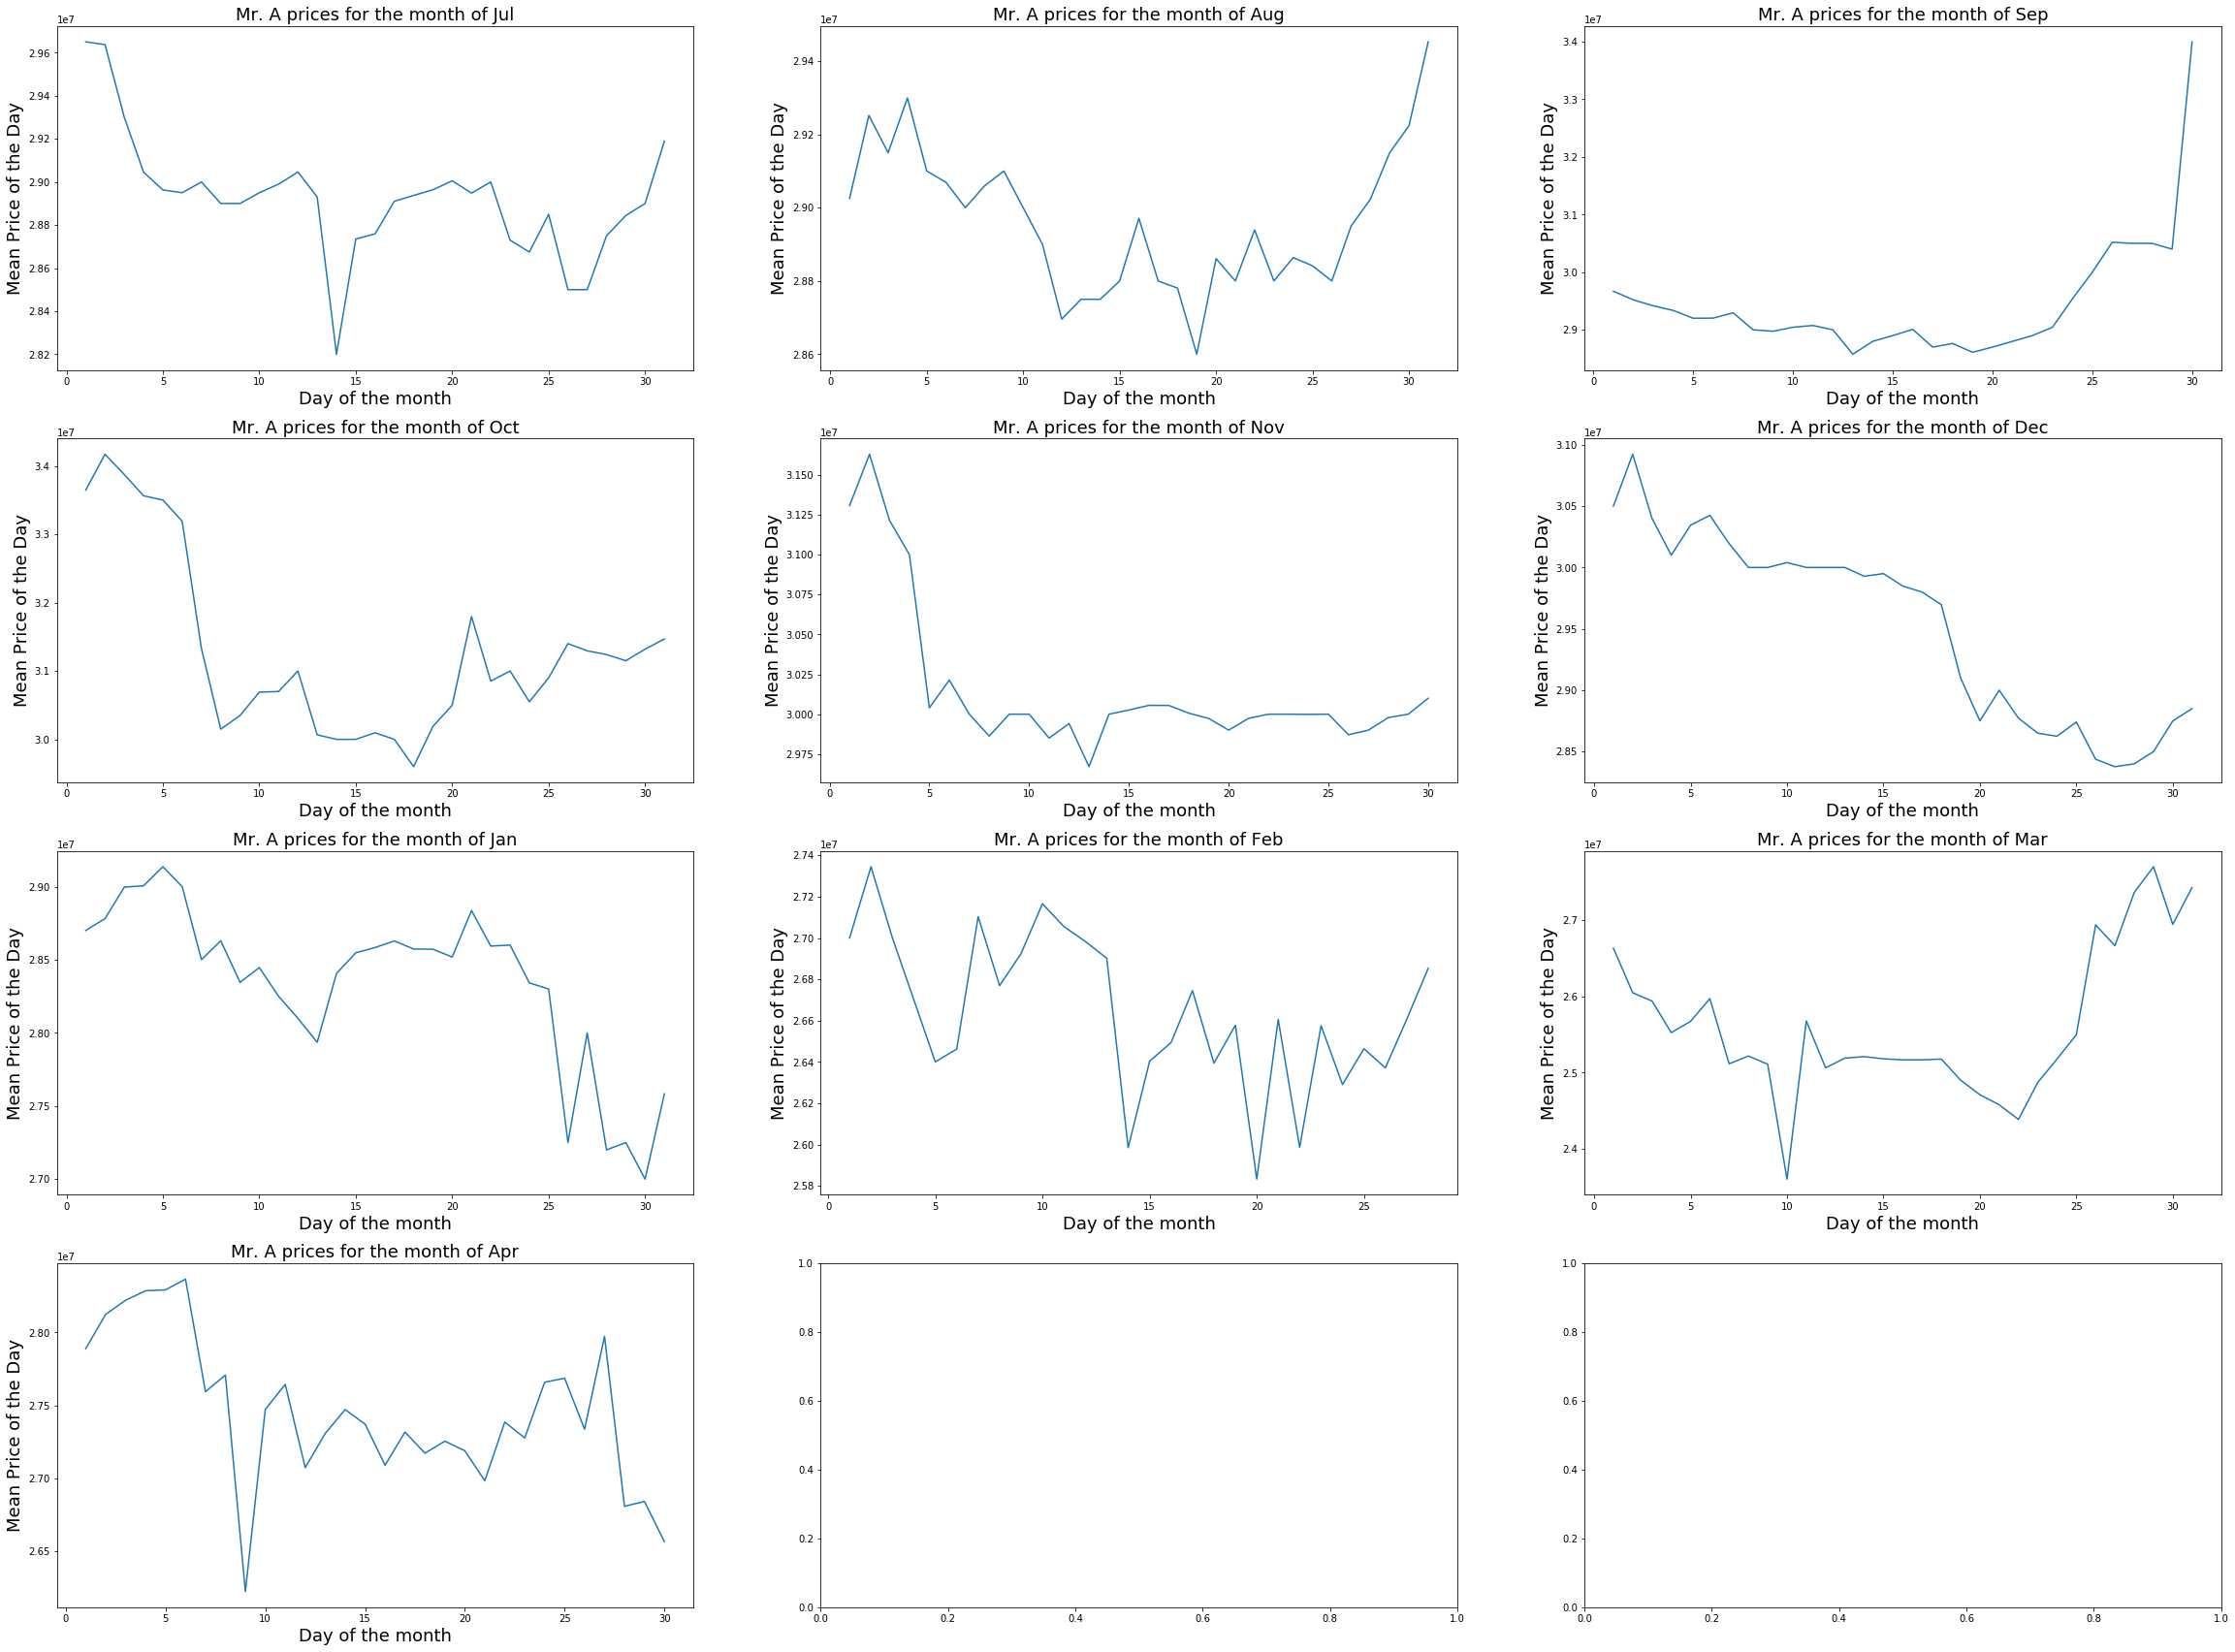

In [18]:
#Constructs graphs of how the mean price varries over tthe course of a month
Months = ['Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr']# The websit is missing half the data for the month of may
f, a = plt.subplots(4,3)
f.set_size_inches(40,30)
for i in range(0,10):
    temp_Data=Day_of_Month_Data[Day_of_Month_Data.index.get_level_values(0)==Months[i]]
    a[int(math.floor(i/3)),int(i%3)].plot(np.array(temp_Data.index.get_level_values(1)),np.array(temp_Data['Cost']))
    a[int(math.floor(i/3)),int(i%3)].set_xlabel('Day of the month', fontsize=18)
    a[int(math.floor(i/3)),int(i%3)].set_ylabel('Mean Price of the Day', fontsize=18)
    a[int(math.floor(i/3)),int(i%3)].set_title('Mr. A prices for the month of '+Months[i], fontsize=18)

So it would seem I have human nature wrong. It seems that perhaps I have projected my own flaws on to humanity in general (I have so few of them that this has never happened before). People are not procrastinators, they are in fact early birds!!! Some times there is a spike in cost near the end of the month as I suggested but far more often (always in fact) there is a spike in cost at the beginning of the month as people rush in to get their shiny new item.

# Simple Predictions
Now lets try to make some predictions. I notice several trends in how the data behaves at the end of the month, but due to the limited size of out set lets keep it simple, either the price goes up at the end of the month or it does not. Very roughly I would say this tends to happen around the 20th day of the month. So I would like to classify when this trend happens. This information would be very useful for directing my investments. Before over thinking a problem it is best to try the simplest possible thing that has a chance at working. So I will start with using a nearest neighbor classification with each month corresponding to a data point and each day being a dimension. First however I will need to get the data in the required form and normalize it else the nearest neighbor approach may simply end up detecting months with similar mean cost. An important note when trying to predict the behavior at the end of the month we will obviously not know the monthly mean so for now rather then the true mean I will use the mean of the first 20 days.

In [19]:
#Compute mean of first 20 days.
Monthly_Mean_Data = Day_of_Month_Data[Day_of_Month_Data.index.get_level_values(1)<=20]
del Monthly_Mean_Data['Cost']
Monthly_Mean_Data = Monthly_Mean_Data.groupby(level=0).sum()
Monthly_Mean_Data['Cost']=Monthly_Mean_Data['Total Cost']/Monthly_Mean_Data['Quantity']
del Monthly_Mean_Data['Quantity']
del Monthly_Mean_Data['Total Cost']
Monthly_Mean_Data.head()

,Cost
Month,
Apr,2.750311e+07
Aug,2.895245e+07
Dec,2.985086e+07
Feb,2.673590e+07
Jan,2.860750e+07


In [20]:
#Create the list of costs of first 20 days and the listt of classes.
X=[]
Y=[0,0,0,1,1,1,1,0,0,1]
for month in Months:
    X.append((np.array(Day_of_Month_Data[Day_of_Month_Data.index.get_level_values(0)==month]['Cost'][0:20])/Monthly_Mean_Data.at[month,'Cost']).tolist())

Due to the very small number of data point the models scores greatly vary depending on the train test split, thus it is important to look at a large number of splits. Since the size of my training set is 7 I will stop looking at the sixth nearest neighbor model. Also it is important to try and keep similar numbers of each class in the train set as in the test set.

In [21]:
#Compute the train and cross validation error for diffrent number of nearest neighbors in the model.
splitter = StratifiedShuffleSplit(n_splits=100,test_size=.3)
for i in range(1,7):#Stop at 6 nearest neighbors as beyond that the whole train set is selected.
    model = KNeighborsClassifier(n_neighbors=i)
    print 'Metrics for '+ str(i)+' nearest neighbor----------------------------------'
    print 'Train accuccary: ' +str(Train_Accucary(model,X,Y,splitter.split(X,Y)))
    print 'CV accucary:'+str(cross_val_score(model,X=X,y=Y,cv=splitter.split(X,Y)).mean())

Metrics for 1 nearest neighbor----------------------------------
Train accuccary: 1.0
CV accucary:0.57
Metrics for 2 nearest neighbor----------------------------------
Train accuccary: 0.642857142857
CV accucary:0.57
Metrics for 3 nearest neighbor----------------------------------
Train accuccary: 0.71
CV accucary:0.583333333333
Metrics for 4 nearest neighbor----------------------------------
Train accuccary: 0.622857142857
CV accucary:0.536666666667
Metrics for 5 nearest neighbor----------------------------------
Train accuccary: 0.632857142857
CV accucary:0.406666666667
Metrics for 6 nearest neighbor----------------------------------
Train accuccary: 0.564285714286
CV accucary:0.463333333333


All and all not a great result but not very surprising given the limited amount of data. I would say that the 1 nearest neighbors looks the best as it has the highest CV accuracy. The low training score on the latter examples (there is guaranteed to be no training error with this models for the 1 nearest neighbor model) indicates that a more complex model might be needed. I will start by trying to find more data however as even with regularization I am very worried about a more complex model over-fitting.

# Again with Feeling (And more data that helps too, BUT MOSTLY FEELING)!!!!

It would seem we need more data. This time however rather then cleaning the stables my quest took the form of navigating a labyrinth as I read long dead forum posts, was guided to website that no longer existed, and clicks on linked that only lead me in circles. No single hero can conquer all villains on their own, they need a side kick or better yet a league. Bested by the labyrinth I turned to my allies at the forums of loathing (the KoL forums) for their assistance. And after only several short days of waiting they pulled through. I now have data all the way back to June 2012 (although there are bits and pieces of it missing and I need to pull from several sources so I still have my work cut out for me).

In [23]:
#Import and orginize the data going back back 2 years
path = os.path.join(os.getcwd(),'Mr_A_2015')
Convert_Kol(path,'Mr_A_2015')
path = os.path.join(os.getcwd(),'Mr_A_2015.csv')
Mr_A_Data_2015 = pd.read_csv(path)
Mr_A_Data_2015['Year']='2015'
path = os.path.join(os.getcwd(),'Mr_A_2016')
Convert_Kol(path,'Mr_A_2016')
path = os.path.join(os.getcwd(),'Mr_A_2016.csv')
Mr_A_Data_2016 = pd.read_csv(path)
Mr_A_Data_2016['Year']='2016'
path = os.path.join(os.getcwd(),'Mr_A_2017')
Convert_Kol(path,'Mr_A_2017')
path = os.path.join(os.getcwd(),'Mr_A_2017.csv')
Mr_A_Data_2017 = pd.read_csv(path)
Mr_A_Data_2017['Year']='2017'
Mr_A_Data = pd.concat([Mr_A_Data_2015,Mr_A_Data_2016,Mr_A_Data_2017])
del Mr_A_Data['Time']
Mr_A_Data['Cost'] = Mr_A_Data['Cost']*Mr_A_Data['Quantity']
Mr_A_Data['Date'] = Mr_A_Data['Year']+'-'+Mr_A_Data['Month']+'-'+Mr_A_Data['Day'].apply(lambda x: str(x))
Mr_A_Data['Date']=Mr_A_Data['Date'].apply(lambda x:dt.datetime.strptime(x, "%Y-%b-%d"))
del Mr_A_Data['Year']
del Mr_A_Data['Month']
del Mr_A_Data['Day']
Mr_A_Data = Mr_A_Data.groupby('Date').sum()
Mr_A_Data['Cost']=Mr_A_Data['Cost']/Mr_A_Data['Quantity']
del Mr_A_Data['Quantity']
Mr_A_Data['Month']=Mr_A_Data.index
Mr_A_Data['Month']=Mr_A_Data['Month'].apply(lambda x: x.replace(day=1))
Mr_A_Data.head()

,Cost,Month
Date,,
2015-06-08,19654800.0,2015-06-01
2015-06-09,19441300.0,2015-06-01
2015-06-10,19000000.0,2015-06-01
2015-06-11,19637100.0,2015-06-01
2015-06-12,19728900.0,2015-06-01


In [24]:
#Import and orginize data from June 2016 to June 2012
data = pd.read_csv('MrA.txt', delimiter='\t')
data['Date']=data['Date'].apply(lambda x:dt.datetime.strptime(str(x), "%Y-%m-%d"))
data['Month']=data['Date'].apply(lambda x: x.replace(day=1))
data.index = data['Date']
del data['Date']
data.head()

,Cost,Month
Date,,
2012-06-25,10090000,2012-06-01
2012-06-26,10100000,2012-06-01
2012-06-27,10194000,2012-06-01
2012-06-28,10290000,2012-06-01
2012-06-29,10550000,2012-06-01


In [25]:
#Combine the two data sets to form one data set to rule them all.
for date in Mr_A_Data.index:
    if not(date in data.index):
        data.loc[date,:]=Mr_A_Data.loc[date,:]

Now lets check how much data is missing and from where.

In [26]:
#Make a table to give an idea of how much missing data there is
month_data = data.copy()
month_data['Number of days']=1
month_data['Early Days']=month_data.index.day
month_data['Early Days']=month_data['Early Days'].apply(lambda x: 1 if x<=20 else 0)
month_data['Mean 20']=month_data['Cost']*month_data['Early Days']
month_data = month_data.groupby('Month').sum()
month_data['Mean Cost']=month_data['Cost']/month_data['Number of days']
month_data['Mean 20']=month_data['Mean 20']/month_data['Early Days']
del month_data['Cost']
print month_data

            Number of days  Early Days       Mean 20     Mean Cost
Month                                                             
2012-06-01               6           0           NaN  1.031067e+07
2012-07-01              30          20  1.050777e+07  1.060785e+07
2012-08-01              26          20  1.070760e+07  1.080200e+07
2012-09-01              21          11  1.080682e+07  1.097519e+07
2012-10-01              30          19  1.146189e+07  1.165863e+07
2012-11-01              29          19  1.184995e+07  1.182598e+07
2012-12-01              27          19  1.155305e+07  1.148704e+07
2013-01-01              25          19  1.171030e+07  1.176159e+07
2013-02-01               5           2  1.188500e+07  1.206300e+07
2013-03-01              29          18  1.214783e+07  1.216914e+07
2013-04-01              28          18  1.216408e+07  1.223811e+07
2013-05-01              29          20  1.265285e+07  1.271534e+07
2013-06-01              26          16  1.242031e+07  1.244377

A lot of data seem to be missing. In order to include a month in our training set at the very least we need two things. We need a day close to the end of the month to be included in our training set preferably the last day but looking at past examples it seems like the second to last day is good enough. Also we would like a large enough number of points to get a pattern from. Thus of the first 20 points I would like at least 18 and I will fill in the missing ones by extending linearly. One thing to point out is that there is a massive increase in the mean in June pf 2015. At first glace this looked odd to me but I have confirmed from past forums posts that this did indeed happen and the data is accurate.

In [27]:
#Removes months where there is no end of month data
for month in month_data.index:
    last_day = dt.datetime(year = month.year,month=month.month,day=calendar.monthrange(month.year,month.month)[1])
    next_to_last_day = dt.datetime(year = month.year,month=month.month,day=calendar.monthrange(month.year,month.month)[1]-1)
    if (not (last_day in data.index)):
        if ((next_to_last_day in data.index)):
            data.loc[last_day,:]=data.loc[next_to_last_day,:]
            data.drop(next_to_last_day)
        else:
            data = data[data['Month']!=month]
            month_data = month_data[month_data.index!=month]

(52, 4)

In [29]:
#Remove months with insufficent data
temp = month_data.copy()
temp = temp[temp['Early Days']<18]
one_day = dt.timedelta(days=1)
for month in temp.index:
    data = data[data['Month']!=month]
    month_data = month_data[month_data.index!=month]
for (month,day) in product(month_data.index,range(1,21)):#Linearly extend to missing points
    date = month.replace(day=day)
    if not(date in data.index):
        if date+one_day in data.index:
            data.loc[date,:]=[(data.loc[date-one_day,'Cost']+data.loc[date+one_day,'Cost'])/2,month]
        else:
            data.loc[date,:]=[data.loc[date-one_day,'Cost'],month]

Even more so then before it is important to normalize the data to the monthly means. As before however we will only use the mean of the first 20 days of the month.

In [30]:
#Normalize the data to the mean of the first 20 days of the month
data['Monthly_Mean']=data['Month'].apply(lambda month: month_data.at[month,'Mean 20'])
data['Normalized Cost']=data['Cost']/data['Monthly_Mean']
data['Full Monthly Mean']=data['Month'].apply(lambda month: month_data.at[month,'Mean Cost'])
data['Full Normalized Cost']=data['Cost']/data['Full Monthly Mean']
data = data.sort_index()
data.head()

,Cost,Month,Monthly_Mean,Normalized Cost,Full Monthly Mean,Full Normalized Cost
Date,,,,,,
2012-07-01,10575000.0,2012-07-01,10507772.25,1.006398,1.060785e+07,0.996903
2012-07-02,10550000.0,2012-07-01,10507772.25,1.004019,1.060785e+07,0.994547
2012-07-03,10640000.0,2012-07-01,10507772.25,1.012584,1.060785e+07,1.003031
2012-07-04,10700000.0,2012-07-01,10507772.25,1.018294,1.060785e+07,1.008687
2012-07-05,10670000.0,2012-07-01,10507772.25,1.015439,1.060785e+07,1.005859


Now to make the training set our data points will be the first 20 days of the month as before. Unlike before we have more examples now, so I can't simply look at graphs to see if the price increased. From the examples before I would say a reasonable price increase is around 100 thousand meat or around %.4 of the value of a Mr. A. So I will mark an example as increasing if the price increased by %.4 from the 20th to the end of the month.

In [31]:
inc_amount = .004
X=[]
Y=[]
f = lambda x, y: 0 if y>x*(1+inc_amount) else 1
for first_day in month_data.index:
    last_day = first_day.replace(day=calendar.monthrange(first_day.year,first_day.month)[1])
    day_20 = first_day.replace(day=20)
    X.append(data.loc[first_day:day_20,'Normalized Cost'].tolist())
    Y.append(f(data.at[day_20,'Normalized Cost'],data.at[last_day,'Normalized Cost']))
print 'There are '+str(sum(Y))+' ones in Y and '+str(len(Y)-sum(Y))+' zeros'

There are 13 ones in Y and 30 zeros


Bucause there are around 2.3 times as many 1s as 0s when when do a train test split we need to be careful to make sure the train and test set have approximately the same number of 1s and 0s. At first I only used one split but everytime I restarted the kernel it (of course) gave diffrent values, this problem was exaserbated by the small size of my data set. So I now work with as many example as possible and adverage over them. I chose 1000 only because I don't feel like waiting very long for my models to run.

In [32]:
#Test several nearest neighbors models
splitter = StratifiedShuffleSplit(n_splits=1000,test_size=.25)
for i in range(1,13):
    model = KNeighborsClassifier(n_neighbors=i)
    print 'Metrics for '+ str(i)+' nearest neighbor----------------------------------'
    print 'Train accuccary: ' +str(Train_Accucary(model,X,Y,splitter.split(X,Y)))
    print 'CV accucary:'+str(cross_val_score(model,X=X,y=Y,cv=splitter.split(X,Y)).mean())
    print 'CV F1 Score:'+str(cross_val_score(model,X=X,y=Y,cv=splitter.split(X,Y),scoring='f1').mean())

Metrics for 1 nearest neighbor----------------------------------
Train accuccary: 1.0
CV accucary:0.457454545455


C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


CV F1 Score:0.174156493506
Metrics for 2 nearest neighbor----------------------------------
Train accuccary: 0.74903125
CV accucary:0.632818181818
CV F1 Score:0.00197619047619
Metrics for 3 nearest neighbor----------------------------------
Train accuccary: 0.69628125
CV accucary:0.602545454545
CV F1 Score:0.0154087301587
Metrics for 4 nearest neighbor----------------------------------
Train accuccary: 0.670375
CV accucary:0.699818181818
CV F1 Score:0.000733333333333
Metrics for 5 nearest neighbor----------------------------------
Train accuccary: 0.67975
CV accucary:0.678454545455
CV F1 Score:0.00562698412698
Metrics for 6 nearest neighbor----------------------------------
Train accuccary: 0.68775
CV accucary:0.719272727273
CV F1 Score:0.0
Metrics for 7 nearest neighbor----------------------------------
Train accuccary: 0.68646875
CV accucary:0.701454545455
CV F1 Score:0.00543333333333
Metrics for 8 nearest neighbor----------------------------------
Train accuccary: 0.68725
CV accucar

At first glace %72.7 accuracy might not seems that bad. However with a little thought we see that this is the accuracy of the model where we always guess the price will not increase, which I will call the guess 0 model. Because of this I have included the f1 score as well as accuracy as a mean to evaluate the model. This model very quickly devolves into the 'guess 0' model on the cv set. Quickly as in for most splits it has already devolved at the two nearest neighbors. The one nearest neighbors models while it does something non-trivial, it does not do anything well, so I will certainly not be sticking with this model.

Overall the results are poor. Even the best (non-guess 0) models do worse them random guessing for many splits. Also in general the training error is also bad. It seems like a different and more complex model is in order. Intuitively that makes sense there are some very large flaws in the nearest neighbor model for this problem.

1) All points are treated approximatly equally so point earlier in the month have as much effect on the model as those latter. It makes sense that days latter in the month should have more effect on the cost at the end of the month.

2) It does not take the slop of a graph into account. If the data for the latter part of two months are just vertical translations of each other then the model might view them as far appart but to our eye the patter looks the same. We can include such feture by looking at linear combinations of fetures such as in an SVM model.

3) When we normalized our model we lost data. It no longer knows what the mean value is. The mean value may be reflective of how good the current item of the month is, so it seems reasonable to suspect that the mean could have some (perhaps even allot) impact on peoples buying habits. I would like to continue to regularize but include the mean (perhaps normalized to the last 6 months or so) as a separate data point.

# SVM

First lets keep it simple and not include the mean and use a linear kernel. It will have the same input as above and I will try a range of value for the regularization parameter C.

In [33]:
splitter = StratifiedShuffleSplit(n_splits=100,test_size=.25)
for k in [.000001,.0001,.001,.01,.1,1,.5,10,100,1000,10000,1000000000,1000000000000]:
    model = SVC(kernel='linear',C=k)
    print '___________________C='+str(k)+'_______________________'
    print 'Train accuccary: ' +str(Train_Accucary(model,X,Y,splitter.split(X,Y)))
    print 'CV accucary:'+str(cross_val_score(model,X=X,y=Y,cv=splitter.split(X,Y)).mean())
    print 'CV F1 Score:'+str(cross_val_score(model,X=X,y=Y,cv=splitter.split(X,Y),scoring='f1').mean())

___________________C=1e-06_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=0.0001_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=0.001_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=0.01_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=0.1_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=1_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=0.5_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=10_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=100_______________________
Train accuccary: 0.6996875


Well the model still sucks but this is diffidently improvement. It now does better then random guessing in terms of accuracy and for large value of C we get much better CV scores as well. Something weird seems to be going on with the scale of the C value. But at least it makes intuitive sense with small Cs forcing the model to be flat and thus making it the guess 0 model thus giving a f1 score of 0. So overall I would choose C to be around 10^9. However we still have a long way to go as I would by no means use this model for investing since the guess 0 model gives better accuracy. For fun let's look at a learning curve to try to get an idea of how to go about improving it.

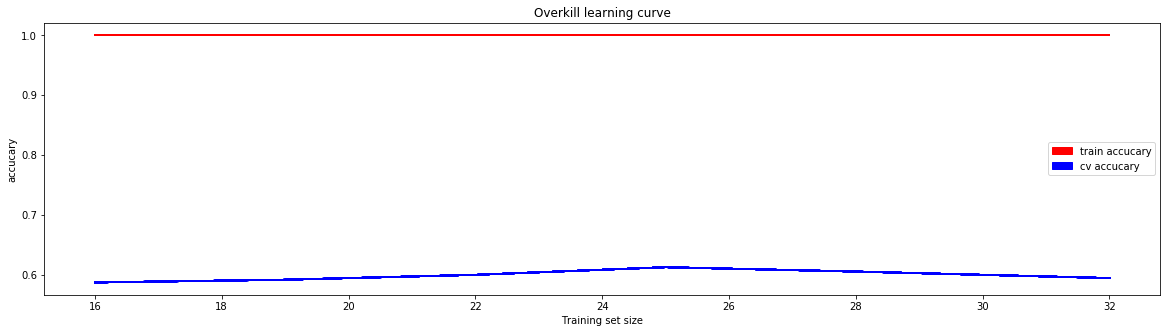

In [34]:
#Make a learning curve.
model = SVC(kernel='linear',C=10**12)
splitter = StratifiedShuffleSplit(n_splits=100,test_size=.25)
set_size, train_accucary, cv_accucary = learning_curve(model,X,Y,train_sizes=[0.5, 0.6,.7,.8,.9,1. ],cv=splitter)
for i in range(0,len(train_accucary)):
    train_accucary[i]=train_accucary[i].mean()
    cv_accucary[i]=cv_accucary[i].mean()
f, a =plt.subplots(1,1)
f.set_size_inches(20,5)
a.plot(set_size,train_accucary,'r')
a.plot(set_size,cv_accucary,'b')
a.set_xlabel('Training set size')
a.set_ylabel('accucary')
a.legend(handles=[mpatches.Patch(color='red', label='train accucary'),mpatches.Patch(color='blue', label='cv accucary')])
a.set_title('Overkill learning curve')

As the title suggests I am aware that this is a bit overkill, the fact that the train accuracy is one already tells me all I need to know. But I wanted to learn how to do it. So it is fairly clear (to no supersize since the dimension of our parameter space is 2/3 the size of our training set and we are highly non-regularized) that we have a high variance problem at the moment and trying more complex models or adding new variables will be pointless until we fix the fact that we are over-fitting like there is no tomorrow (that is assuming that if there is no tomorrow you would want to spend your last time on earth over-fitting models and lets be honest who wouldn't?).

We could try to increasing the regularization by modifying C, but we saw earlier that that while that does lower the training error it does so at the cost of our cv score. So first lets try reducing the number of variables. As always I will try the easiest thing first and just cut the first 10 days, since it seems reasonable that the first 10 days have less impact on the end of the month then the middle 10.

In [35]:
#Compute score for a model with half the parameters
trunc_X=[]
for x in X:
    trunc_X.append(x[10:])
print len(trunc_X)
print len(trunc_X[3])
splitter = StratifiedShuffleSplit(n_splits=100,test_size=.25)
for k in [.000001,.0001,.001,.01,.1,1,.5,10,100,1000,10000,1000000000,1000000000000]:
    model = SVC(kernel='linear',C=k)
    print '___________________C='+str(k)+'_______________________'
    print 'Train accuccary: ' +str(Train_Accucary(model,trunc_X,Y,splitter.split(trunc_X,Y)))
    print 'CV accucary:'+str(cross_val_score(model,X=trunc_X,y=Y,cv=splitter.split(trunc_X,Y)).mean())
    print 'CV F1 Score:'+str(cross_val_score(model,X=trunc_X,y=Y,cv=splitter.split(trunc_X,Y),scoring='f1').mean())

43
10
___________________C=1e-06_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=0.0001_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=0.001_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=0.01_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=0.1_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=1_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=0.5_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=10_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=100_______________________
Train accuccary: 0.69

Well this lowered our train error but our model is performing about the same. So it seems like removing those was a good choice since we simplified our model at no cost. Lets try two more simplifications and see how they work out.

In [36]:
#Look at latest 5 terms
trunc_X=[]
for x in X:
    trunc_X.append(x[15:])
splitter = StratifiedShuffleSplit(n_splits=100,test_size=.25)
for k in [.000001,.0001,.001,.01,.1,1,.5,10,100,1000,10000,1000000000,1000000000000]:
    model = SVC(kernel='linear',C=k)
    print '___________________C='+str(k)+'_______________________'
    print 'Train accuccary: ' +str(Train_Accucary(model,trunc_X,Y,splitter.split(trunc_X,Y)))
    print 'CV accucary:'+str(cross_val_score(model,X=trunc_X,y=Y,cv=splitter.split(trunc_X,Y)).mean())
    print 'CV F1 Score:'+str(cross_val_score(model,X=trunc_X,y=Y,cv=splitter.split(trunc_X,Y),scoring='f1').mean())

___________________C=1e-06_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=0.0001_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=0.001_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=0.01_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=0.1_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=1_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=0.5_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=10_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=100_______________________
Train accuccary: 0.69125
CV

In [37]:
#Look at only last term
#Stops running before thtte lastt value of C not sure why
trunc_X=[]
for x in X:
    trunc_X.append(x[len(x)-2:])
splitter = StratifiedShuffleSplit(n_splits=100,test_size=.25)
for k in [.1,1,.5,10,100,10**3,10**4,10**5,10**6,10**7,10**8,10**9]:
    model = SVC(kernel='linear',C=k)
    print '___________________C='+str(k)+'_______________________'
    print 'Train accuccary: ' +str(Train_Accucary(model,trunc_X,Y,splitter.split(trunc_X,Y)))
    print 'CV accucary:'+str(cross_val_score(model,X=trunc_X,y=Y,cv=splitter.split(trunc_X,Y)).mean())
    print 'CV F1 Score:'+str(cross_val_score(model,X=trunc_X,y=Y,cv=splitter.split(trunc_X,Y),scoring='f1').mean())

___________________C=0.1_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=1_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=0.5_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=10_______________________
Train accuccary: 0.6875
CV accucary:0.727272727273
CV F1 Score:0.0
___________________C=100_______________________
Train accuccary: 0.6915625
CV accucary:0.726363636364
CV F1 Score:0.0
___________________C=1000_______________________
Train accuccary: 0.6971875
CV accucary:0.713636363636
CV F1 Score:0.0
___________________C=10000_______________________
Train accuccary: 0.701875
CV accucary:0.71
CV F1 Score:0.0
___________________C=100000_______________________
Train accuccary: 0.7003125
CV accucary:0.709090909091
CV F1 Score:0.0
___________________C=1000000_______________________
Train accuccary: 0.71031

So in terms of accuracy the more complex model is not doing much better (though it does have a much better CV score). Then the model with only two parameters which can equivalently be formulated as the cost on day 20 and the approximate slope on day 20. Let's see if adding in a term to capture the monthly mean price relative to nearby months will help at all.

In [38]:
#Add in a flag for each month indicating wether on no the price increased near the end of the month
month_data['No Inc Flag']=0
f = lambda x, y: 0 if y>x*(1+inc_amount) else 1
for month in month_data.index:
    last_day = month.replace(day=calendar.monthrange(month.year,month.month)[1])
    day_20 =month.replace(day=20)
    month_data.at[month,'No Inc Flag']=f(data.at[day_20,'Normalized Cost'],data.at[last_day,'Normalized Cost'])

So when normalizing the monthly mean we need to look at two special cases. One is the first 6 months where there are not 6 months before them. If I had unlimited data I would just throw these away. As I do not I will just use the 6th closed months. This should be good enough as it will still given a general feel for how high the mean is. Two is that there is a large jump in the mean in the June of 2016. I don't want to have 6 months means were some month are on one side and others are on the other. So I will do the same thing as before and just look at the six nearest months on the same side of the jump.

In [39]:
#create a column for the mean of the last 6 months
temp = month_data.copy()
month_data['Relative Mean']=0
month_data['Mean of last 6 months']=0#not including month you are in
disscont = list(month_data.index).index(dt.datetime(year=2015,month=7,day=1))
for i in range(0,6):#loop over first 4 month where we cant just look back four months
    mean = 0
    month_range=range(0,7)
    del month_range[i]
    for j in month_range:
        mean = mean+month_data.at[month_data.index[j],'Mean Cost']
    month_data.at[month_data.index[i],'Mean of last 6 months']=mean/6
    mean = 0
    for j in month_range:
        mean = mean+month_data.at[month_data.index[disscont+j],'Mean Cost']
    month_data.at[month_data.index[disscont+i],'Mean of last 6 months']=mean/6
for i in (range(6,disscont)+range(disscont+6,len(month_data.index))):
    mean = 0
    for j in range(1,7):
        mean = mean+month_data.at[month_data.index[i-j],'Mean Cost']
    month_data.at[month_data.index[i],'Mean of last 6 months']=mean/6
month_data['Relative Mean']=month_data['Mean 20']/month_data['Mean of last 6 months']

Mean of relative means when the price does not increase: 1.02914846967
Mean of relative means when the price does increase: 1.00480277196
Standard diviation: 0.0759716173074


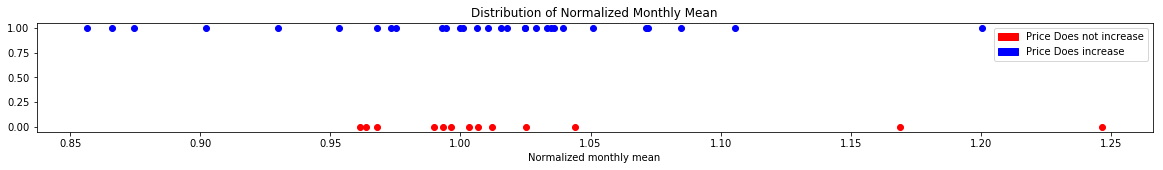

In [40]:
#Create a plot to help tell if the nomralized monthly mean will be a usefull parameter
RM1=month_data[month_data['No Inc Flag']==1]['Relative Mean'].mean()
RM2=month_data[month_data['No Inc Flag']==0]['Relative Mean'].mean()
stdiv = month_data['Relative Mean'].std()
print 'Mean of relative means when the price does not increase: ' +str(RM1)
print 'Mean of relative means when the price does increase: ' +str(RM2)
print 'Standard diviation: '+str(stdiv)
f, a =plt.subplots(1,1)
f.set_size_inches(20,2)
a.plot(list(month_data[month_data['No Inc Flag']==1]['Relative Mean']),[0]*len(list(month_data[month_data['No Inc Flag']==1]['Relative Mean'])),'ro')
a.plot(list(month_data[month_data['No Inc Flag']==0]['Relative Mean']),[1]*len(list(month_data[month_data['No Inc Flag']==0]['Relative Mean'])),'bo')
a.set_xlabel('Normalized monthly mean')
a.legend(handles=[mpatches.Patch(color='red', label='Price Does not increase'),mpatches.Patch(color='blue', label='Price Does increase')])
a.set_title('Distribution of Normalized Monthly Mean')

So I can't discern much of a pattern from this, it seems unlikely that including the mean will do much to improve our model, perhaps the left outliers could be of some use. At the moment I am going to give up on this model in its entirety. As no notrivial model even seems to get close to the guess 0 model.

# Conclusions

It seems I would need new parameters to make it work. One thing I could look into is volume data it seems like if people are rushing to buy an item of the month at the end of the month then less of them should have sold by the 20th. Unfortunately at the moment I only have volume data for the first two years. Another thing I could look into is more qualitative data. There are pages and pages of forum posts of people evaluating and discussing the items of the month, perhaps I could come up with 1-5 rating on how good the item is a different things and use that.

In [44]:
mean_temp =[]
data['Day']=data.index.day
for i in range(0,5):
    temp = data[data['Day']<=i+5]
    temp = data[data['Day']>=i+1]
    mean_temp.append(temp['Full Normalized Cost'].mean())
del data['Day']
for i in range(0,5):
    print 'Mean cost Mr. As sold at during days '+str(i*5+1)+'-'+str(i*5+5)+': '+str(mean_temp[i])

Mean cost Mr. As sold at during days 1-5: 1.00011052393
Mean cost Mr. As sold at during days 6-10: 0.999854999355
Mean cost Mr. As sold at during days 11-15: 0.999414139807
Mean cost Mr. As sold at during days 16-20: 0.999029859412
Mean cost Mr. As sold at during days 21-25: 0.998701766177


So for lack of a better model if we assume we buy at a random time between days 16-20 and sell at a random time between days 21-25. we can expect to get a .00141 monthly interest. For a total of .0487 yearly interest or %4.87. This strategically however is not recommended. As when we look back to our graph of amount purchased vs price we see that the price can fairly regularly fluctuate by %7 of the value of a Mr. Accessory over the span of only 14 days. The only reason so not just use buying at these sales would be if one has more meat then these sales give them opportunities to spend.